# Floating Array Design Project, Deep Case, Humboldt

## Imports and Styling

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Configuration

First, we need to set the library path, and then we'll load the configuration file, to show some of
the configurations. For a complete guide and definition, please see either the
[API documentation](https://nrel.github.io/WAVES/api.html) or the
[How to use WAVES guide](https://nrel.github.io/WAVES/getting_started.html#configuring).

In [2]:
library_path = Path("../library/FAD/")
config_floating = load_yaml(library_path / "project/config", "base_floating_deep.yaml")

# This example was designed prior to the FLORIS 3.6 release, so the path to the turbine library in
# FLORIS must be manually updated, but this example must work for all users, so a dynamic method
# is used below, ensuring this works for all users.
config_floating["floris_config"] = load_yaml(library_path / "project/config", config_floating["floris_config"])

config_floating["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"

Now, we'll create a Project for each of the fixed bottom and floating offshore scenarios, showing
the time it takes to initialize each project. Note that we're initializing using the
`Project.from_dict()` `classmethod` because the configurations are designed to also work with the
WAVES command line interface (CLI).

In [3]:
# Add in the library path for both configurations
config_floating.update({"library_path": library_path,})



start2 = perf_counter()

project_floating = Project.from_dict(config_floating)
1
end2 = perf_counter()
print(f"Floating loading time: {(end2-start2):,.2f} seconds")

'H' is deprecated and will be removed in a future version, please use 'h' instead.

ORBIT library intialized at 'C:\iea49\WAVES\library\FAD'
Floating loading time: 9.13 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

### Visualize the wind farm

Both projects use the same layout, so we'll plot just the fixed bottom plant, noting that the self-connected line at the "OSS1" indicates the unmodeled interconnection point via a modeled export cable.

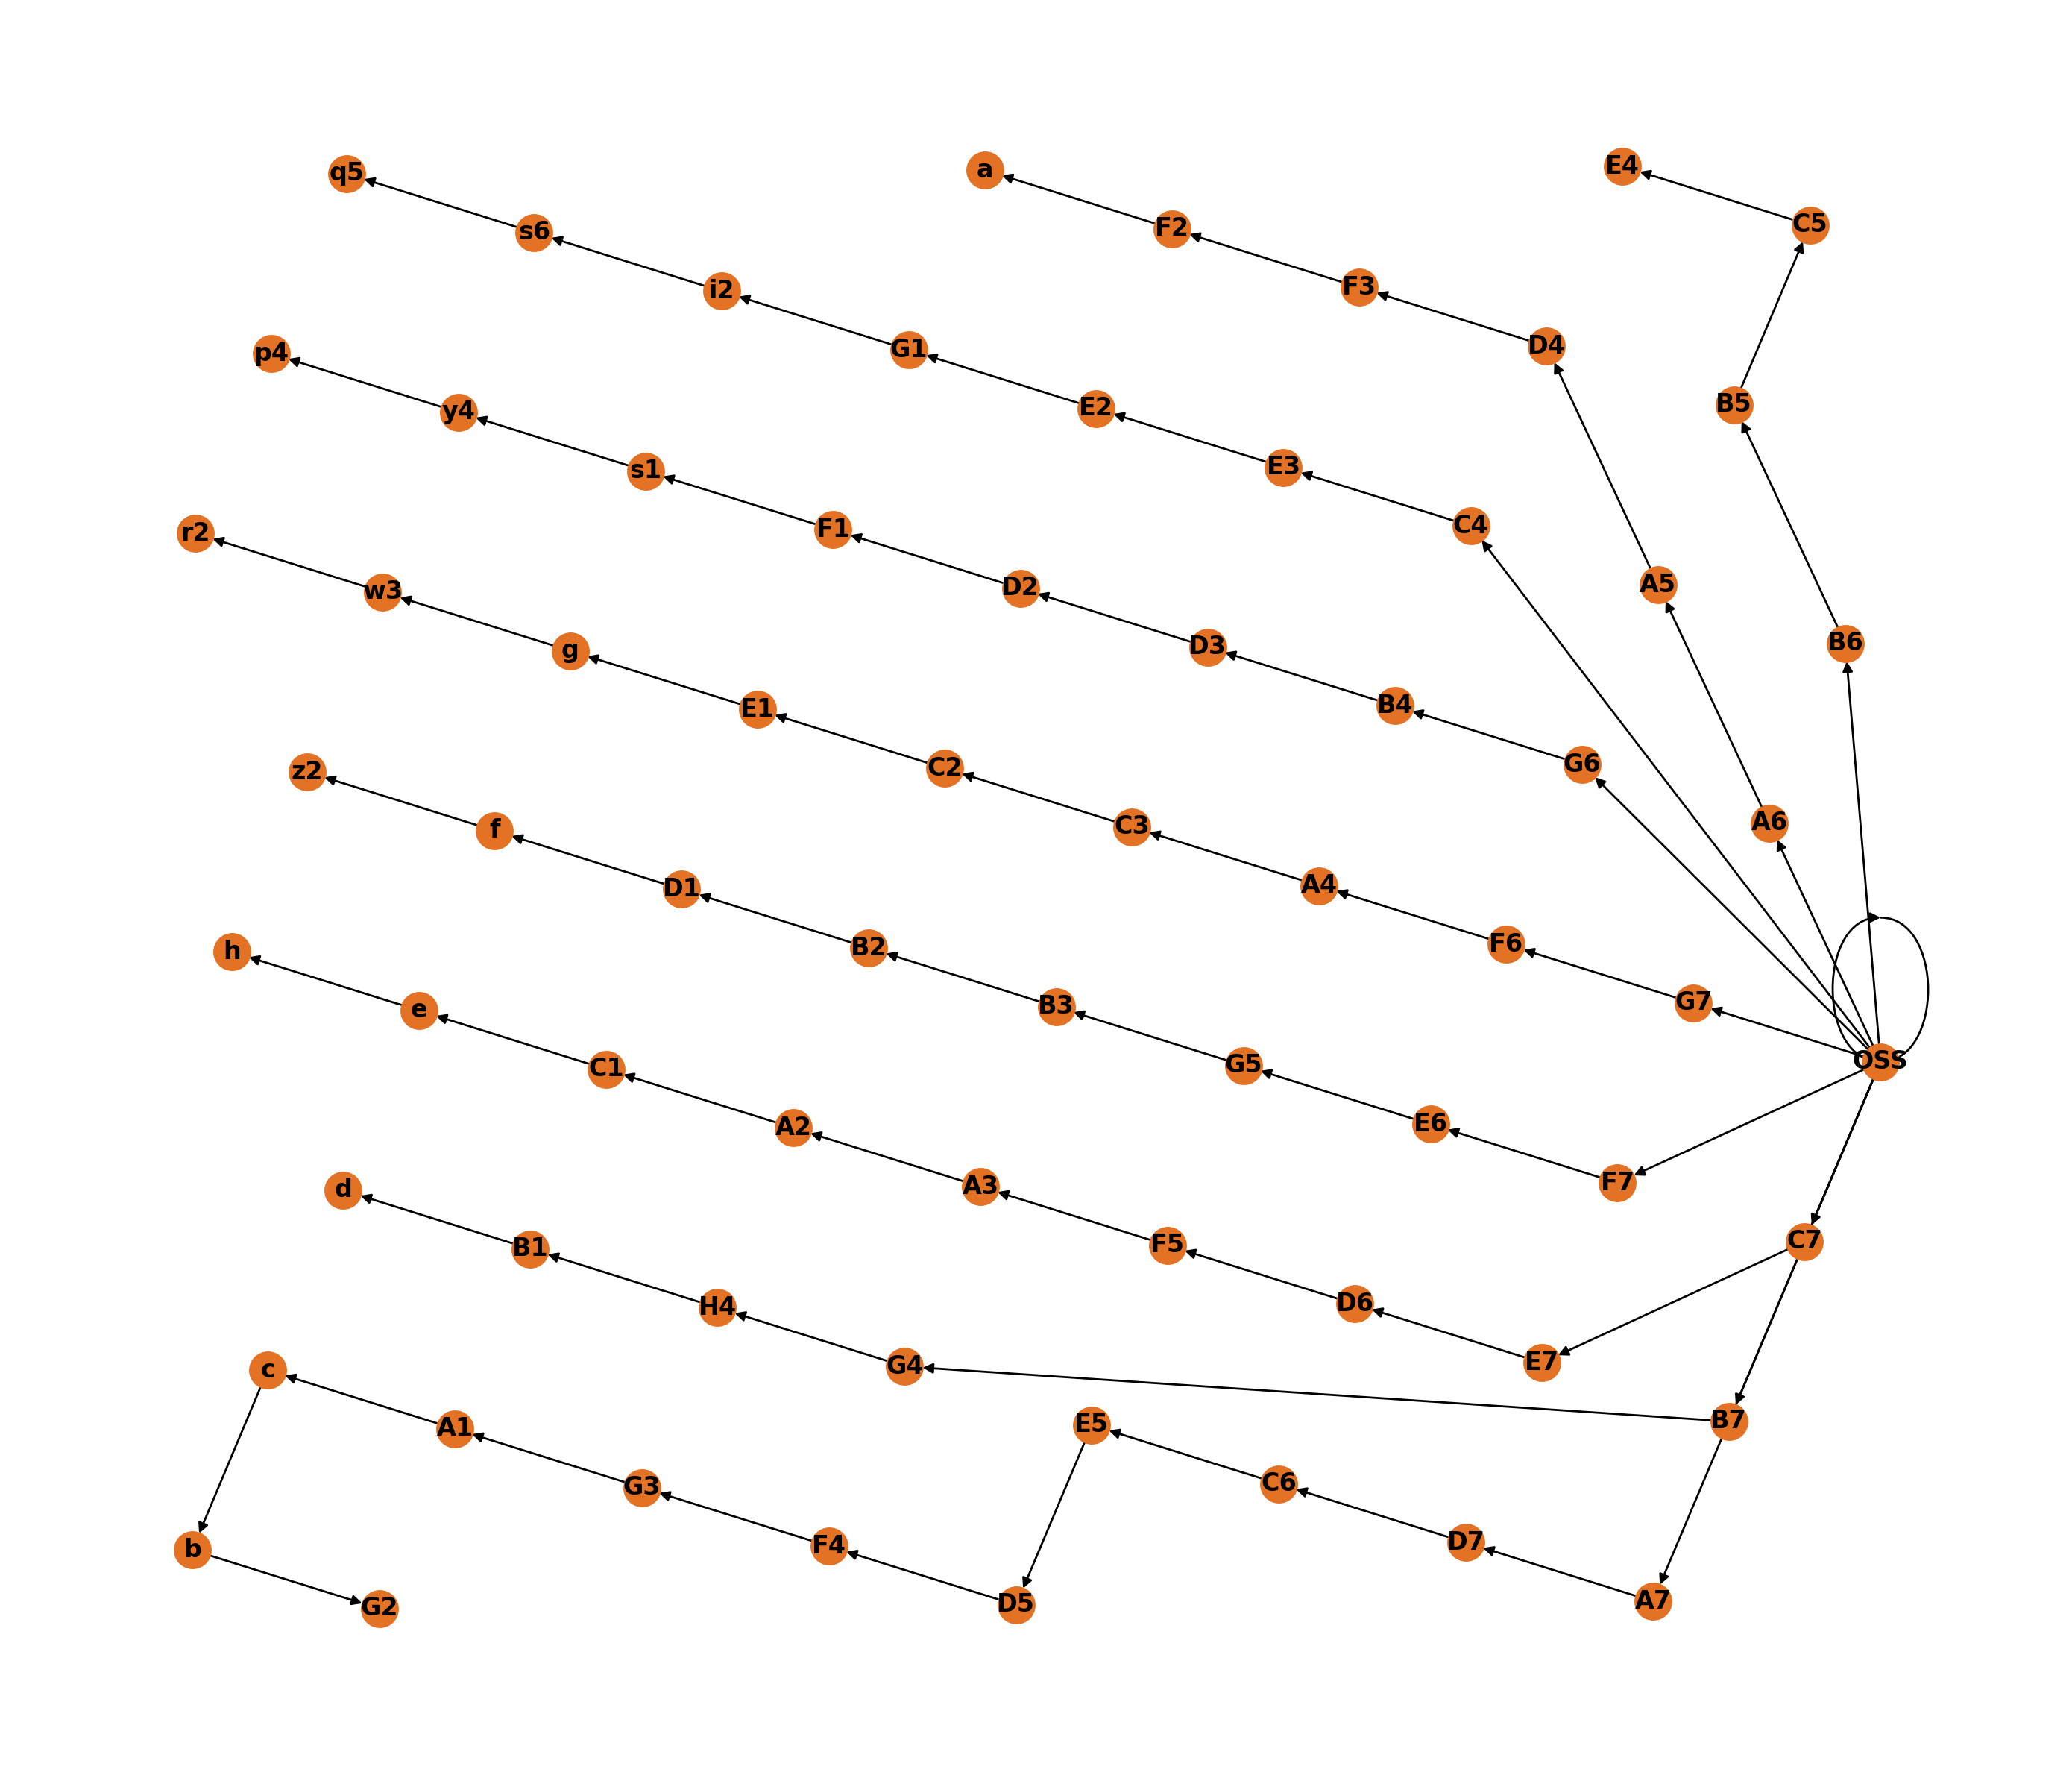

In [4]:
project_floating.plot_farm()

## Run the Projects

Now we'll, run all both the fixed-bottom and floating offshore wind scenarios. Notice that there are
additional parameters to use for running the FLORIS model in WAVES: `"wind_rose"` and
`"time_series"`. While time series is more accurate, it can take multiple hours to run for a
20-year, hourly timeseries, and lead to similar results, so we choose the model that will take only
a few minutes to run, instead.

Additionally, the wind rose can be computed based on the full weather profile,
`full_wind_rose=True`, for little added computation since WAVES computes a wind rose for each month
of the year, for a more accurate energy output. However, we're using just the weather profile used
in the O&M phase: `full_wind_rose=False`.

In [5]:
start2 = perf_counter()
project_floating.run(
    which_floris="wind_rose",
    full_wind_rose=False,
    floris_reinitialize_kwargs=dict(cut_in_wind_speed=3.0, cut_out_wind_speed=25.0)
)
project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end2 = perf_counter()

print("-" * 29)  # separate our timing from the ORBIT and FLORIS run-time warnings
print(f"Floating run time: {end2 - start2:,.2f} seconds")

Missing data in columns ['bury_speed']; all values will be calculated.

Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
-----------------------------
Floating run time: 875.78 seconds


In [6]:
df = pd.DataFrame(project_floating.orbit.phases["MooringSystemInstallation"].env.actions)
display(df)

,cost_multiplier,agent,action,duration,cost,level,time,phase,phase_name
0,1.00,Mooring System Installation Vessel,Mobilize,168.00,"1,050,000.00",ACTION,0.00,MooringSystemInstallation,NaN
1,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,5.00,MooringSystemInstallation,MooringSystemInstallation
2,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,10.00,MooringSystemInstallation,MooringSystemInstallation
3,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,15.00,MooringSystemInstallation,MooringSystemInstallation
4,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,20.00,MooringSystemInstallation,MooringSystemInstallation
...,...,...,...,...,...,...,...,...,...
895,NaN,Mooring System Installation Vessel,Install Mooring Line,4.00,"25,000.00",ACTION,"6,614.90",MooringSystemInstallation,MooringSystemInstallation
896,NaN,Mooring System Installation Vessel,Position Onsite,2.00,"12,500.00",ACTION,"6,616.90",MooringSystemInstallation,NaN
897,NaN,Mooring System Installation Vessel,Perform Mooring Site Survey,4.00,"25,000.00",ACTION,"6,620.90",MooringSystemInstallation,MooringSystemInstallation
898,NaN,Mooring System Installation Vessel,Install Suction Pile Anchor (IEA 49),15.00,"93,750.00",ACTION,"6,635.90",MooringSystemInstallation,MooringSystemInstallation


Both of these examples can also be run via the CLI, though the FLORIS `turbine_library_path`
configuration will have to be manually updated in each file to ensure the examples run.

```console
waves path/to/library/base_2022/ base_fixed_bottom_2022.yaml base_floating_bottom_2022.yaml --no-save-report
```

(example_cower_2022:results)=
## Gather the results

Another of the conveniences with using WAVES to run all three models is that some of the core
metrics are wrapped in the `Project` API, with the ability to generate a report of a selection of
the metrics.

Below, we define the inputs for the report by the following paradigm, where the `"metric"` and
`"kwargs"` keys must not be changed to ensure their values are read correctly. See the following
setup for details.

```python
configuration_dictionary = {
    "Descriptive Name of Metric": {
        "metric": "metric_method_name",
        "kwargs": {
            "metric_kwarg_1": "kwarg_1_value", ...
        }
    }
}
```

Below, it can be seen that many metrics do not have the `"kwargs"` dictionary item. This is because
an empty dictionary can be assumed to be used when no values need to be configured. In other words,
the default method configurations will be relied on, if not otherwise specified.

In [7]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True, "with_losses": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True, "with_losses": True}
    },
    "Net Capacity Factor With Wake Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net", "with_losses": True}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With Wake Losses (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

Before we generate the report, let's see a CapEx breakdown of each scenario. To do this, we'll
access ORBIT's `ProjectManager` object directly to access model-specific functionality. This is
available for each model via:

- `project.orbit`: provides access to ORBIT's `ProjectManager`
- `project.wombat` provides access to WOMBAT's `Simulation`
- `project.floris` provides access to FLORIS's `FlorisInterface`

In [8]:
# Capture the CapEx breakdown from each scenario

df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Floating"]
)


df_capex_floating["CapEx ($/kW) - Floating"] = df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")

df_capex_floating

,Component,CapEx ($) - Floating,CapEx ($/kW) - Floating
0,Array System,"53,296,253.35",53.03
1,Export System,"293,277,216.78",291.82
2,Substructure,"984,432,572.82",979.53
3,Mooring System,"164,283,732.00",163.47
4,Offshore Substation,"154,546,456.67",153.78
5,Array System Installation,"116,460,244.70",115.88
6,Export System Installation,"107,254,283.09",106.72
7,Substructure Installation,"316,588,620.39",315.01
8,Mooring System Installation,"65,922,108.76",65.59
9,Offshore Substation Installation,"5,209,630.15",5.18


Now, let's generate the report, and then add in some additional reporting variables.

In [9]:
project_name_floating = "FAD Deep Case - Floating"

# Generate the reports using WAVES and the above configurations
# NOTE: the results are transposed to view them more easily for the example, otherwise
# each row would be a project, which is helpful for combining the results of many scenarios
report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T

# Gather some additional metadata and results from the projects
n_years_floating = project_floating.operations_years

additional_reporting_floating = pd.DataFrame(
    [
        ["FCR (%)", project_floating.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_floating.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
        ],
    ],
    columns=["Project"] + report_df_floating.columns.tolist(),
).set_index("Project")

# Combine the additional metrics to the generated report
report_df_floating = pd.concat((report_df_floating, additional_reporting_floating), axis=0).loc[metrics_order]

# Combine both reports into one, easy to view dataframe
report_df = report_df_floating
report_df.index.name = "Metrics"

# Format percent-based rows to show as such, not as decimals
report_df.loc[report_df.index.str.contains("%")] *= 100

report_df

,FAD Deep Case - Floating
Metrics,
# Turbines,67.00
Turbine Rating (MW),15.00
Project Capacity (MW),"1,005.00"
# OSS,1.00
Total Export Cable Length (km),206.53
Total Array Cable Length (km),133.24
FCR (%),6.48
Offtake Price ($/MWh),83.30
CapEx ($),"4,839,596,118.71"


In [10]:
project_floating.wombat.metrics.opex(frequency='annual', by_category=True)

,operations,port_fees,equipment_cost,total_labor_cost,materials_cost,OpEx
year,,,,,,
1999,"5,999,850.00","25,000,000.00","7,733,958.91",0,794480,"39,528,288.91"
2000,"6,016,287.95","25,000,000.00","12,214,816.75",0,3880100,"47,111,204.69"
2001,"5,999,850.00","25,000,000.00","31,357,726.41",0,4797052,"67,154,628.41"
2002,"5,999,850.00","25,000,000.00","13,933,035.82",0,4815000,"49,747,885.82"
2003,"5,999,850.00","25,000,000.00","32,852,743.15",0,4975480,"68,828,073.15"
2004,"6,016,287.95","25,000,000.00","28,775,470.03",0,3291232,"63,082,989.98"
2005,"5,999,850.00","25,000,000.00","36,538,328.55",0,2439960,"69,978,138.55"
2006,"5,999,850.00","25,000,000.00","50,039,234.89",0,3599252,"84,638,336.89"
2007,"5,999,850.00","25,000,000.00","39,883,632.47",0,1988160,"72,871,642.47"


In [11]:
project_floating.wombat.metrics.equipment_costs(frequency="annual", by_equipment=True)

,Anchor Handling Tug,Cable Lay Vessel,Crew Transfer Vessel 1,Crew Transfer Vessel 2,Crew Transfer Vessel 3,Diving Support Vessel 1,Diving Support Vessel 2
year,,,,,,,
1999,"2,294,110.64","1,746,446.34",0.00,0.00,0.00,"3,071,946.75","621,455.18"
2000,"2,995,754.33","5,042,735.68","1,391,815.56","1,392,697.84","1,391,813.34",0.00,0.00
2001,"7,001,303.70","13,487,318.56","1,389,063.69","1,388,176.08","1,389,060.68","4,962,581.46","1,740,222.24"
2002,"7,654,398.94","2,109,778.39","1,389,618.40","1,389,620.99","1,389,619.10",0.00,0.00
2003,"9,362,945.82","5,880,463.33","1,388,882.46","1,388,882.60","1,388,886.78","8,322,742.27","5,119,939.90"
2004,"6,930,848.56","5,142,068.78","1,392,672.86","1,392,673.74","1,392,675.71","11,249,591.15","1,274,939.24"
2005,"10,575,528.75","3,508,587.08","1,388,865.70","1,388,866.03","1,388,863.90","11,752,102.12","6,535,514.98"
2006,"14,056,288.66","4,442,679.77","1,388,871.38","1,388,869.33","1,388,872.11","16,649,313.37","10,724,340.28"
2007,"9,933,608.33","2,909,776.45","1,388,865.47","1,388,863.23","1,388,864.41","14,320,095.32","8,553,559.26"


In [12]:
# Years is dependent on if the weather profile contains leap years. In the COREWIND
# data, this is the case, so 365.25 should be used in place of 365
years = round((project_floating.wombat.env.end_datetime - project_floating.wombat.env.start_datetime).days / 365.25, 2)

#print(years)

metrics = project_floating.wombat.metrics

#print(metrics)
ev = project_floating.wombat.metrics.events
#print(ev)

## Annual average materials costs

The `metrics.component_costs` does not fully delineate the breakdown available in your
slides, so I would recommend the following calculation to get the subassembly costs by
failure mode. I will plan to implement this in WOMBAT so the math can be behind the
scenes.

In [13]:
materials = (
    ev
    .loc[
        ev.materials_cost.gt(0)
        #& ev.request_id.startsiwth("RPR"),  # NOTE: remove this filter to include maintenance costs
        & ev.request_id.str.startswith("RPR"),  # NOTE: remove this filter to include maintenance costs
        ["part_name", "reason", "materials_cost"]
]
)
materials.loc[materials.part_name.str.startswith("ARR"), "part_name"] = "array cable"
materials.loc[materials.part_name.str.startswith("EXP"), "part_name"] = "export cable"
total_materials = materials.groupby(["part_name", "reason"]).sum() / years

In [14]:
total_materials

materials_cost
part_name            reason                                                   
array cable          array cable major repair                        45,714.29
                     array cable replacement                        230,476.19
drive_train          main shaft major repair                         24,666.67
                     main shaft minor repair                         15,714.29
                     main shaft replacement                         187,809.52
electrical_system    power converter major repair                   179,000.00
                     power converter minor repair                    53,761.90
                     power converter replacement                    343,095.24
                     power electrical system major repair             6,666.67
                     power electrical system major replacement        2,380.95
                     power electrical system minor repair            33,714.29
generator            direct drive generator major repair             61,457.14
                     direct drive generator major replacement       259,023.81
                     direct drive generator minor repair             77,714.29
hydraulic_system     major pitch system repair                       33,023.81
                     major pitch system replacement                     666.67
                     minor ballast pump repair                          952.38
                     minor pitch system repair                       39,523.81
rotor_blades         blades major repair                             17,244.00
                     blades major replacement                        25,428.57
                     blades minor repair                            210,857.14
supporting_structure anchor replacement                             219,428.57
                     buoyancy module replacement                    314,285.71
                     major anchor repair                             78,571.43
                     marine growth removal                           18,071.43
                     mooring line major repair                       16,190.48
                     mooring line replacement                        70,714.29
transformer          oss minor repair                                   666.67
yaw_system           yaw system major repair                            714.29
                     yaw system major replacement                     1,190.48
                     yaw system minor repair                          4,261.90

## Average annual failures

This number of failures in a simulation can be computed using the `metrics.process_times()`
method, but it does not include the subassembly category. To attach the subassembly data
for plotting, we can join the annual occurrences with the above materials costs breakdown.
As a note, if the maintenance tasks are filtered out of the materials costs, then the
default left join will filter out the maintenance occurrences as well.

In [15]:
timing = (
    metrics
    .process_times()[["N"]]
    .rename(columns={"N": "annual_occurrences"})
    / years
)

average_failures_costs = (
    total_materials
    .reset_index(drop=False)
    .rename(columns={"part_name": "subassembly", "reason": "category"})
    .set_index("category")
    .join(timing)
    .reset_index(drop=False)
    .set_index(["subassembly", "category"])
)

In [16]:
timing

,annual_occurrences
category,
anchor replacement,3.10
annual turbine inspection,272.76
array cable major repair,1.67
array cable replacement,1.10
blades major repair,1.24
blades major replacement,0.10
blades minor repair,59.33
buoyancy module replacement,9.10
direct drive generator major repair,7.57


In [17]:
average_failures_costs

materials_cost  \
subassembly          category                                                    
array cable          array cable major repair                        45,714.29   
                     array cable replacement                        230,476.19   
drive_train          main shaft major repair                         24,666.67   
                     main shaft minor repair                         15,714.29   
                     main shaft replacement                         187,809.52   
electrical_system    power converter major repair                   179,000.00   
                     power converter minor repair                    53,761.90   
                     power converter replacement                    343,095.24   
                     power electrical system major repair             6,666.67   
                     power electrical system major replacement        2,380.95   
                     power electrical system minor repair            33,714.29   
generator            direct drive generator major repair             61,457.14   
                     direct drive generator major replacement       259,023.81   
                     direct drive generator minor repair             77,714.29   
hydraulic_system     major pitch system repair                       33,023.81   
                     major pitch system replacement                     666.67   
                     minor ballast pump repair                          952.38   
                     minor pitch system repair                       39,523.81   
rotor_blades         blades major repair                             17,244.00   
                     blades major replacement                        25,428.57   
                     blades minor repair                            210,857.14   
supporting_structure anchor replacement                             219,428.57   
                     buoyancy module replacement                    314,285.71   
                     major anchor repair                             78,571.43   
                     marine growth removal                           18,071.43   
                     mooring line major repair                       16,190.48   
                     mooring line replacement                        70,714.29   
transformer          oss minor repair                                   666.67   
yaw_system           yaw system major repair                            714.29   
                     yaw system major replacement                     1,190.48   
                     yaw system minor repair                          4,261.90   

                                                                annual_occurrences  
subassembly          category                                                       
array cable          array cable major repair                                 1.67  
                     array cable replacement                                  1.10  
drive_train          main shaft major repair                                  3.24  
                     main shaft minor repair                                 29.00  
                     main shaft replacement                                   1.33  
electrical_system    power converter major repair                            95.14  
                     power converter minor repair                           149.71  
                     power converter replacement                             21.43  
                     power electrical system major repair                     5.43  
                     power electrical system major replacement                0.43  
                     power electrical system minor repair                    97.76  
generator            direct drive generator major repair                      7.57  
                     direct drive generator major replacement                 2.14  
                     direct drive generator minor repair                    145.57

# Vessel delay summary

The best way to address the specific utilization of each vessel is to break down
the cause of delays, which I am outlining below. As a note, I am shortening the 
actual delay messages to common categories so that the delays are appropriately
grouped.

In [18]:
delay_summary = (
    ev
    .loc[
        ev.agent.isin(project_floating.wombat.service_equipment)
        & ev.duration.gt(0)
        & ev.action.eq("delay"),
        ["agent", "additional", "duration"]
    ]
    .groupby(["agent", "additional"])
    .sum()
    .reset_index(drop=False)
    .replace({
        "no work requests submitted by start of shift": "no requests",
        "no work requests, waiting until the next shift": "no requests",
        "weather unsuitable to transfer crew": "weather delay",
        "work shift has ended; waiting for next shift to start": "end of shift",
        "insufficient time to complete travel before end of the shift": "end of shift",
        "will return next year": "end of charter",
    })
    .set_index(["agent", "additional"])
    / 24
)

In [19]:
delay_summary

duration
agent                   additional                                           
Anchor Handling Tug     no requests                                  3,864.21
                        weather delay                                  133.22
                        weather delay                                    7.83
                        end of shift                                     2.29
Cable Lay Vessel        no requests                                     17.46
                        weather delay                                   78.42
                        weather delay                                   24.49
                        end of shift                                   285.89
Crew Transfer Vessel 1  no requests                                  4,432.83
                        weather delay                                  418.04
                        weather delay                                  156.71
                        end of charter                                 365.25
                        end of shift                                   579.36
Crew Transfer Vessel 2  no requests                                  4,669.73
                        not in working hours                             0.45
                        weather delay                                  412.41
                        weather delay                                  144.41
                        end of charter                                 365.25
                        end of shift                                   531.48
Crew Transfer Vessel 3  no requests                                  4,298.08
                        weather delay                                  459.84
                        weather delay                                  158.20
                        end of charter                                 365.25
                        end of shift                                   613.14
Diving Support Vessel 1 no requests                                  2,829.79
                        weather delay                                    7.37
                        weather delay                                    3.32
                        end of shift                                    41.92
Diving Support Vessel 2 no requests                                  1,785.76
                        weather delay                                    2.51
                        weather delay                                    1.00
                        end of shift                                     6.20
Tugboat 1               end of shift                                    18.66
                        weather delay                                  105.89
                        weather unsuitable for mooring reconnection     51.00
                        weather unsuitable for unmooring                39.00
Tugboat 2               end of shift                                    21.61
                        weather delay                                   99.47
                        weather unsuitable for mooring reconnection     55.50
                        weather unsuitable for unmooring                32.50

# Vessel mobilization summary

The builtin mobilization cost summary in the service equipment costs likely does not
provide all the information needed, so below demonstrates how to get the number of
mobilizations, days spent mobilizing, and the total cost of mobilization by vessel.

In [20]:
mobilization_summary = (
    ev
    .loc[ev.action.eq("mobilization") & ev.duration.gt(0), ["agent", "duration"]]
    .groupby("agent")
    .count()
    .rename(columns={"duration": "mobilizations"})
    .join(
        ev
        .loc[ev.action.eq("mobilization"), ["agent", "duration", "equipment_cost"]]
        .groupby("agent")
        .sum()
    )
)
mobilization_summary.duration /= 24

In [21]:
mobilization_summary

,mobilizations,duration,equipment_cost
agent,,,
Anchor Handling Tug,41,574.00,"13,325,000.00"
Cable Lay Vessel,41,574.00,"22,288,244.11"
Diving Support Vessel 1,35,525.00,"7,875,000.00"
Diving Support Vessel 2,30,450.00,"6,750,000.00"
